## Controller Design with Pole Placement

### Steps:
1. Import the best model
2. Use **tf2zp( )** to see all poles & zeros location
3. Use **minreal( )** to see if pole zero cancellation
4. Find dominant pole(s) to reduce system order
5. Use a simple step responsee to show that the reduced order system can still correctly resemble the system

### Create ARMAX model
The ARMAX model is based on the paper "Heat Exchanger Model (Data-driven modelling)"

In [160]:
num = [0.0001701, 0.0001295];          % B
den = [1, -0.2492, -0.7469, 0, 0, 0];  % A
Ts = 0.001;
sys = tf(num, den, Ts)


sys =
 
     0.0001701 z + 0.0001295
  -----------------------------
  z^5 - 0.2492 z^4 - 0.7469 z^3
 
Sample time: 0.001 seconds
Discrete-time transfer function.




### Pole-Zero Cancellation
Can use this to simplify the model if there exists pole-zero cancellation

In [53]:
sys = minreal(sys, 1e-3)   % in this case, it does not


sys =
 
     0.0001701 z + 0.0001295
  -----------------------------
  z^5 - 0.2492 z^4 - 0.7469 z^3
 
Sample time: 4 seconds
Discrete-time transfer function.




### Check system poles, zeros, DC gain
Use function **[z, p, k] = tf2zp(num, den)** ([link](https://se.mathworks.com/help/signal/ref/tf2zp.html))

In [83]:
[z, p, k] = tf2zp(num, den)


z =

   -0.7613


p =

         0
         0
         0
    0.9978
   -0.7486


k =

   1.7010e-04




### Find Dominant Poles to Reduce System Order
From the output above, the system poles are at 0, 0, 0, 0.9978, -0.7486 <br>
The dominant poles in a discrete system are the ones that are closest to the unit circle <br>
Thus, the dominant poles are at 0.9978, -0.7486. The system can thus be reduced to 2nd-order

In [163]:
z = tf('z', Ts);
sys_dominant = k*(z+0.7613)/((z-0.9978)*(z+0.7486))  % remember to include the DC gain (k)


sys_dominant =
 
  0.0001701 z + 0.0001295
  -----------------------
  z^2 - 0.2492 z - 0.747
 
Sample time: 0.001 seconds
Discrete-time transfer function.




### To proof that the reduced-order system is still a good approximate of the original system
Easy example: <br>
* step( ): for plotting system response
* stepinfo( ): retrieve information

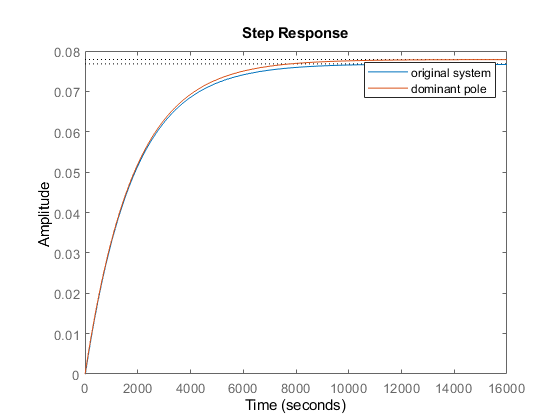

In [85]:
step(sys, sys_dominant)
legend({'original system', 'dominant pole'})

From the output below it is clear that ***sys*** and ***sys_dominant*** are almost identical

In [35]:
S = stepinfo(sys)
display('--------------------------')
S = stepinfo(sys_dominant)


S = 

  struct with fields:

        RiseTime: 98.4000
    SettlingTime: 175.6000
     SettlingMin: 0.0692
     SettlingMax: 0.0767
       Overshoot: 0
      Undershoot: 0
            Peak: 0.0767
        PeakTime: 275.9000

--------------------------

S = 

  struct with fields:

        RiseTime: 99.8000
    SettlingTime: 177.7000
     SettlingMin: 0.0701
     SettlingMax: 0.0779
       Overshoot: 0
      Undershoot: 0
            Peak: 0.0779
        PeakTime: 437.9000




This step is just to convert the poles to continuous time. The rest is just to double check if the converted poles are correct.


pole_cont =

   -3.4777
   -0.0006


zero_cont =

   -3.6894
    0.5000


sys_cont_proof =
 
   s^2 + 3.189 s - 1.845
  ------------------------
  s^2 + 3.478 s + 0.002086
 
Continuous-time transfer function.


k_d =

    0.0779


k_c =

 -884.2393


sys_cont_proof =
 
    -s^2 - 3.189 s + 1.845
  --------------------------
  884.2 s^2 + 3075 s + 1.845
 
Continuous-time transfer function.




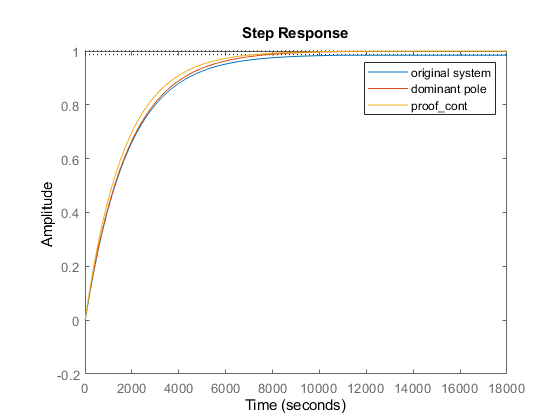

In [87]:
sys_cont = d2c(sys_dominant, 'tustin');

pole_cont = pole(sys_cont)
zero_cont = zero(sys_cont)

s = tf('s');
sys_cont_proof = ((s-0.5)*(s+3.6894))/((s+0.0006)*(s+3.477))

% check dc gain
% k = DC gain of original system
k_d = dcgain(sys_cont) % k_d : sys_dominant = sys_cont
k_c = dcgain(sys_cont_proof)
sys_cont_proof = sys_cont_proof/k_c

step((sys/k_d), (sys_cont/k_d), sys_cont_proof)
legend({'original system', 'dominant pole', 'proof_cont'})

### From the chart above we can confirm that:
1. Choosing the dominant pole to reduce the system order is possible (sys_dominant)
2. Transform the discrete transfer function (sys_dominant) into continuous time is possible (sys_cont, sys_cont_proof)
3. We also retrieve the dominant poles in continuous time are at -0.0006 and -3.4777

## Pole Placement
In this particular case, the system is reduced to second order.    <br>

1. A general form of a second order system can be shown as $G_p$:  <br>
> $G_p = \frac{B}{A} = \frac{b_{1}z + b_{0}}{z^{2}+a_{1}z+a_{0}}$  <br>

In [48]:
% Retreive coefficients of the plant
[num, den] = tfdata(sys_dominant);
b1 = num{1}(2);  b0 = num{1}(3);
a1 = den{1}(2);  a0 = den{1}(3);

Choose poles: <br>
$A_m \rightarrow (w_m, \zeta_m)$ <br>
$A_o \rightarrow (w_o)$ 

In [88]:
%--- A_m ------
w_m = -35;  % 10 times faster, origial is at -3.4777
zeta_m = 0.7;

%--- A_o ------
w_o = 80;

2. A general form of a PI controller in discrete time can be shown as $G_c$: <br>
> $G_c = \frac{S}{R} = P + I \frac{T_s}{z-1}$                                <br>

3. Diophantine equation $A_{cl}$:                                                        <br>
> $A_{cl} = AR+BS = ( z^{2}+a_{1}z+a_{0} )( z-1 ) + ( b_{1}z + b_{0} )( Pz+IT_{s}-P )$   <br>

4. Desired equation $A_{d} = A_{m}(z)A_{o}(z)$: <br>
> $deg(A_{cl}) = deg(A_{d})  = 3 $              <br>
> $deg(A_{m}) = deg(G_{p})   = 2 $              <br>
> $deg(A_{o}) = deg(A_{d}) - deg(A_{m}) = 1$    <br>

5. Designing $A_{d}$ and $A_{o}$:                                                <br>
* A first order general discrete form is:                                        <br>
> $A_{o} = z-e^{-w_{o}T_{s}} = p_0$                                              <br>

* A second order general discrete form is:                                             <br>
> $A_{m} = (z-z_{1})(z-z_{2}) = z^2-(z_{1}+z_{2})+z_{1}z_{2} = z^2- p_2 z+ p_1 $       <br>
> $p_2 = z_{1} + z_{2} = 2e^{-\zeta_{m} w_{m} T_{s}} \cos(w_{m}T_{s} \sqrt{1-\zeta_{m}^2}) $   <br>
> $p_1 = z_{1}z_{2} = e^{-2\zeta_{m} w_{m}T_{s}}$                                          <br>

Note that choosing a pole $w_{o}$ at continuous time is associating to the pole $e^{-w_{o}T_{s}}$ in discrete time

In [133]:
%--- A_m ------
p2 = 2*exp(-zeta_m*w_m*Ts)*cos(w_m*Ts*sqrt(1-(zeta_m)^2)); % z1 + z2
p1 = exp(-2*zeta_m*w_m*Ts); % z1*z2

%--- A_o ------
p0 = exp(-w_o*Ts);

In [134]:
% Diophantine Eqn A_cl = AR + BS
syms P I z
A_cl = (z^2+a1*z+a0)*(z-1) + (b1*z+b0)*(P*z + I*Ts - P);
A_d = (z^2-p2*z+p1)*(z-p0);
A_cl_c = fliplr(coeffs(A_cl, z)); % retreive coeficients
A_d_c = fliplr(coeffs(A_d, z));     % retreive coeficients

In [135]:
% Solve Eqn
equ1 = A_cl_c(2) == A_d_c(2); % z^2
equ2 = A_cl_c(3) == A_d_c(3); % z^1
equ3 = A_cl_c(4) == A_d_c(4); % z^0

sol = solve([equ1, equ2, equ3], [P, I]);

P = double(sol.P)
I = double(sol.I)


P =

  0x1 empty double column vector


I =

  0x1 empty double column vector




<div class="alert-info">
Note that Num of Diophantine Eqn > Num of Control Parameters. In this case, the system is unsolvable <br>
Solution: <br>
Add a Derivative with low pass filter
</div>

6. Add a low pass filter to our PI controller in discrete time $G_c$:          <br>
> $G_c = \frac{S}{R} = P + I \frac{T_s}{z-1} + D \frac{(z-1)N}{z-1+NTs}$       <br>
> where N is the low pass filter 

$A_{cl}$ thus becomes a 4th-order polynomial. This results in both $A_{m}$ and $A_{o}$ become 2nd-order. <br>
$A_{d} = A_{m}A_{o} = (z^2-p_3z+p_2)(z^2-p_1z+p_0)$, where
> $p_3 = 2e^{-\zeta_{m} w_{m} T_{s}} \cos(w_{m}T_{s} \sqrt{1-\zeta_{m}^2}) $   <br>
> $p_2 = e^{-2\zeta_{m} w_{m}T_{s}}$                                           <br>
> $p_1 = 2e^{-\zeta_{o} w_{o} T_{s}} \cos(w_{o}T_{s} \sqrt{1-\zeta_{o}^2}) $   <br>
> $p_0 = e^{-2\zeta_{o} w_{o}T_{s}}$                                           <br>

Thus, we have to choose $(w_m, \zeta_m)$ and $(w_o, \zeta_o)$

In [139]:
%--- A_m ------
w_m = -35;  % 10 times faster, origial is at -3.4777
zeta_m = 0.7;

%--- A_o ------
w_o = 80;
zeta_o = zeta_m;

In [140]:
%--- A_m ------
p3 = 2*exp(-zeta_m*w_m*Ts)*cos(w_m*Ts*sqrt(1-(zeta_m)^2));
p2 = exp(-2*zeta_m*w_m*Ts);

%--- A_o ------
p1 = 2*exp(-zeta_o*w_o*Ts)*cos(w_o*Ts*sqrt(1-(zeta_o)^2));
p0 = exp(-2*zeta_o*w_o*Ts);

In [141]:
% Diophantine Eqn A_cl = AR + BS
syms P I D N z
A_cl = (z^2+a1*z+a0)*(z-1)*(z-1+N*Ts) + (b1*z+b0)*(z-1)*(z-1+N*Ts)*P + N*D*(z-1)^2 + I*Ts*(z-1+N*Ts); % 4th order
A_d = (z^2-p3*z+p2)*(z^2-p1*z+p0);
A_cl_c = fliplr(coeffs(A_cl, z)); % retreive coeficients
A_d_c = fliplr(coeffs(A_d, z));     % retreive coeficients

In [142]:
% Solve Eqn
equ1 = A_cl_c(2) == A_d_c(2); % z^3
equ2 = A_cl_c(3) == A_d_c(3); % z^2
equ3 = A_cl_c(4) == A_d_c(4); % z^1
equ4 = A_cl_c(5) == A_d_c(5); % z^0

sol = solve([equ1, equ2, equ3, equ4], [P, I, D, N]);

P = double(sol.P)
I = double(sol.I)
D = double(sol.D)
N = double(sol.N)


P =

   1.0e+03 *

   -9.9129
   -9.9317
   -0.0125


I =

   -4.8253
    4.6741
   -0.0045


D =

   -1.8852
    1.8295
   -0.0017


N =

   1.0e+03 *

   -0.0016
    0.0016
   -1.6856




<div class="alert-warning">
Not sure why P I D N solutions are not single value
</div>

In [153]:
P = P(1);
D = D(1);
I = I(1);
N = N(1);

In [154]:
z = tf('z', Ts);
G_c = P + D*(((z-1)*N)/(z-1+N*Ts)) + I*Ts/(z-1)


G_c =
 
  -9910 z^2 + 1.984e04 z - 9926
  -----------------------------
      z^2 - 2.002 z + 1.002
 
Sample time: 0.001 seconds
Discrete-time transfer function.




In [166]:
t_o = (1-p3+p2)/(b1+b0);
A_o = [1, -p1, p0];
T = t_o*A_o;
R = [1, N-1, -N];
G_ff = tf(T, R, Ts)


G_ff =
 
  4.19 z^2 - 7.911 z + 3.746
  --------------------------
    z^2 - 2.574 z + 1.574
 
Sample time: 0.001 seconds
Discrete-time transfer function.




In [167]:
Gyr = G_ff*sys_dominant/(1+G_c*sys_dominant)


Gyr =
 
  0.0007128 z^7 - 0.002407 z^6 + 0.001957 z^5 + 0.001639 z^4 - 0.002917 z^3 + 0.000484 z^2 + 0.0008939 z - 0.0003629
  ------------------------------------------------------------------------------------------------------------------
             z^8 - 6.76 z^7 + 15.43 z^6 - 10.16 z^5 - 11.06 z^4 + 17.85 z^3 - 3.078 z^2 - 5.612 z + 2.391
 
Sample time: 0.001 seconds
Discrete-time transfer function.




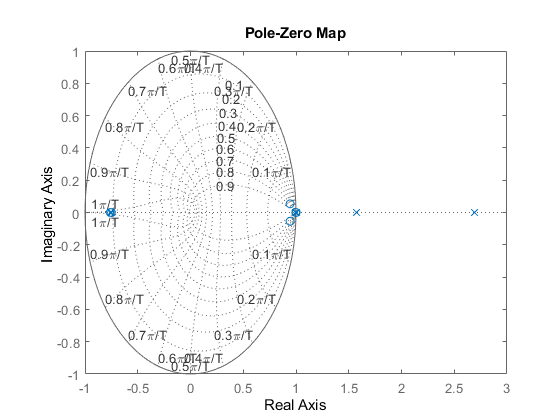

In [168]:
pzmap(Gyr)
grid on;